data exploering

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [21]:
# Let's assume df is your dataframe
# If you need to load your data
df= pd.read_csv('/preprocessed_data.csv')


In [22]:
# Step 1: Handle missing values
print("Missing values before imputation:")
print(df.isnull().sum())

# Impute missing values with mean strategy
imputer = SimpleImputer(strategy='mean')
df[['luxury_sales', 'fresh_sales', 'dry_sales', 'cluster_catgeory']] = imputer.fit_transform(
    df[['luxury_sales', 'fresh_sales', 'dry_sales', 'cluster_catgeory']]
)

print("\nMissing values after imputation:")
print(df.isnull().sum())

Missing values before imputation:
Customer_ID          0
outlet_city          0
luxury_sales        10
fresh_sales          9
dry_sales            8
cluster_catgeory     0
dtype: int64

Missing values after imputation:
Customer_ID         0
outlet_city         0
luxury_sales        0
fresh_sales         0
dry_sales           0
cluster_catgeory    0
dtype: int64


In [23]:
# Step 2: Check if cluster_catgeory is continuous or categorical
unique_values = df['cluster_catgeory'].unique()
print(f"\nUnique values in cluster_catgeory: {sorted(unique_values)}")
print(f"Total unique values: {len(unique_values)}")

# Convert to int if it's categorical with few values
if len(unique_values) < 15:  # Assuming it's categorical if fewer than 15 unique values
    df['cluster_catgeory'] = df['cluster_catgeory'].astype(int)
    print("Converted cluster_catgeory to integer type for classification")


Unique values in cluster_catgeory: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]
Total unique values: 6
Converted cluster_catgeory to integer type for classification


In [24]:
# Step 3: Prepare features and target
X = df[['outlet_city', 'luxury_sales', 'fresh_sales', 'dry_sales']]
y = df['cluster_catgeory']

In [25]:
# Step 4: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(unique_values) < 15 else None
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")



Training data shape: (619248, 4)
Testing data shape: (154813, 4)


In [26]:
# Step 5: Create a simple Decision Tree model first
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [27]:
# Step 6: Evaluate the basic model
y_pred = dt_model.predict(X_test)
print("\n--- Basic Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Basic Model Evaluation ---
Accuracy: 0.9985

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     37793
           2       1.00      1.00      1.00     31010
           3       1.00      1.00      1.00      9778
           4       1.00      1.00      1.00     34486
           5       1.00      1.00      1.00      7905
           6       1.00      1.00      1.00     33841

    accuracy                           1.00    154813
   macro avg       1.00      1.00      1.00    154813
weighted avg       1.00      1.00      1.00    154813



In [28]:
# Step 7: Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
        Feature  Importance
3     dry_sales    0.438583
1  luxury_sales    0.250871
2   fresh_sales    0.234051
0   outlet_city    0.076496


In [ ]:

# Step 8: Hyperparameter tuning with Grid Search
print("\n--- Performing Hyperparameter Tuning ---")
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


--- Performing Hyperparameter Tuning ---


In [32]:
# Step 9: Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("\n--- Tuned Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))


--- Tuned Model Evaluation ---
Accuracy: 0.9990

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     37793
           2       1.00      1.00      1.00     31010
           3       1.00      1.00      1.00      9778
           4       1.00      1.00      1.00     34486
           5       1.00      1.00      1.00      7905
           6       1.00      1.00      1.00     33841

    accuracy                           1.00    154813
   macro avg       1.00      1.00      1.00    154813
weighted avg       1.00      1.00      1.00    154813



In [33]:
# Step 10: Cross-validation of the best model
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV score: {cv_scores.mean():.4f}")
print(f"Standard deviation of CV scores: {cv_scores.std():.4f}")


Cross-validation scores: [0.99879209 0.99899879 0.99922487 0.99902462 0.99876625]
Mean CV score: 0.9990
Standard deviation of CV scores: 0.0002


In [36]:

# Step 11: Visualize the decision tree (only if it's not too large)
if best_model.get_depth() < 10:
    plt.figure(figsize=(20, 10))
    plot_tree(best_model, feature_names=X.columns,
              class_names=[str(c) for c in best_model.classes_],
              filled=True, rounded=True, fontsize=10)
    plt.title("Decision Tree Visualization")
    plt.show()
else:
    print(f"\nTree is too deep ({best_model.get_depth()} levels) to visualize effectively")


Tree is too deep (20 levels) to visualize effectively


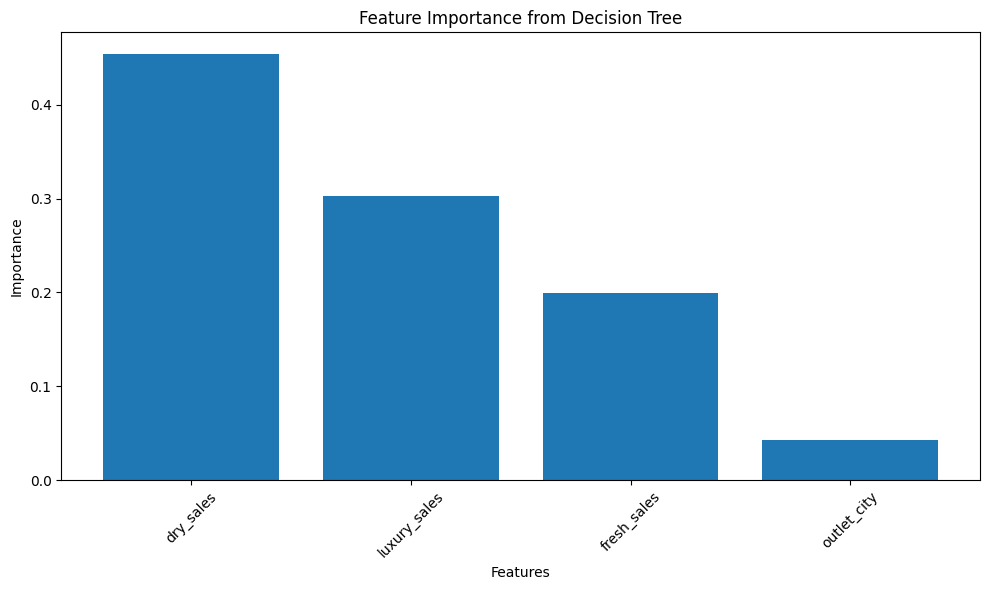

In [37]:
# Step 12: Visualize feature importance for the best model
best_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(best_feature_importance['Feature'], best_feature_importance['Importance'])
plt.title('Feature Importance from Decision Tree')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

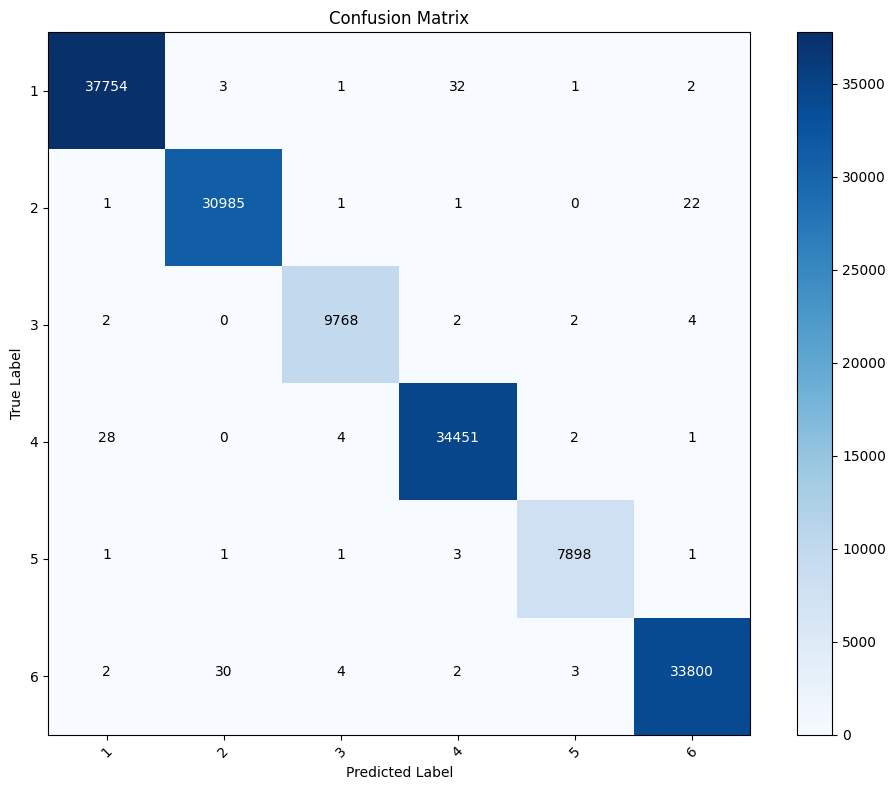

In [38]:
# Step 13: Confusion Matrix visualization
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(best_model.classes_))
plt.xticks(tick_marks, best_model.classes_, rotation=45)
plt.yticks(tick_marks, best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add text annotations to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()


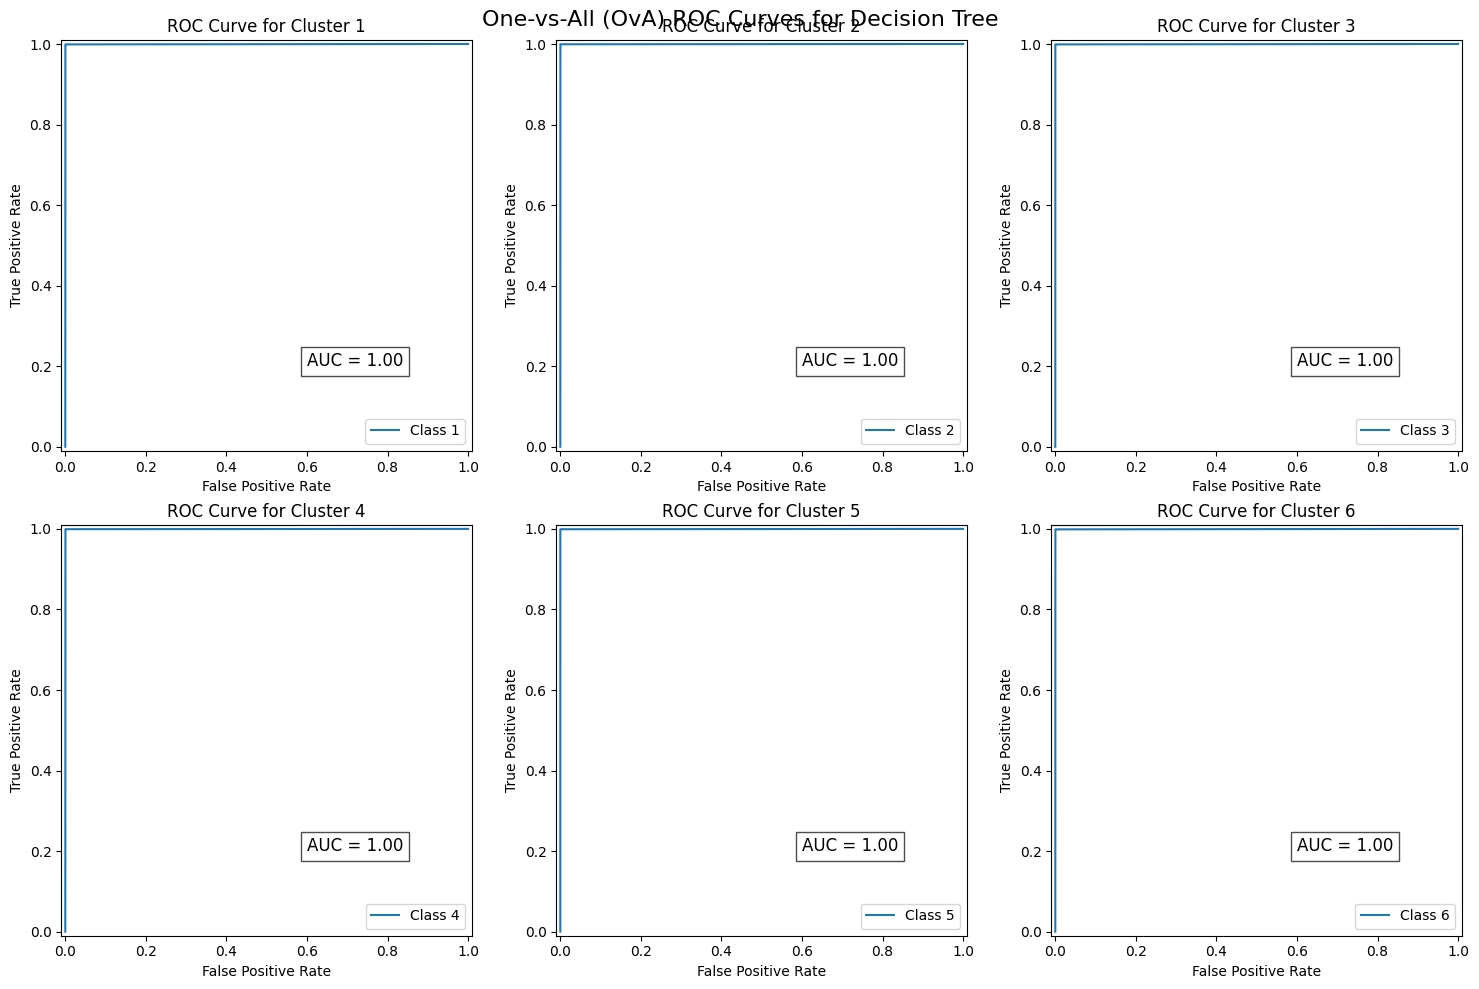


AUC scores per class:
Class 1: 0.9994
Class 2: 0.9995
Class 3: 0.9995
Class 4: 0.9995
Class 5: 0.9995
Class 6: 0.9993
Average AUC: 0.9994


In [39]:
# ROC Curve for Decision Tree Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import label_binarize

# Get predicted probabilities for each class
y_prob = best_model.predict_proba(X_test)

# Create a figure with subplots - determine number of classes dynamically
n_classes = len(best_model.classes_)
n_cols = 3
n_rows = (n_classes + n_cols - 1) // n_cols  # Ceiling division for number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
# Flatten axes for easier indexing
axes = axes.flatten() if n_classes > 1 else [axes]

# Plot ROC curves for each class
for i, class_label in enumerate(best_model.classes_):
    if i < len(axes):  # Make sure we don't exceed available axes
        fpr, tpr, _ = roc_curve(y_test == class_label, y_prob[:, i])
        auc = roc_auc_score(y_test == class_label, y_prob[:, i])  # Calculate AUC
        RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'Class {class_label}').plot(ax=axes[i])
        axes[i].text(0.6, 0.2, f'AUC = {auc:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
        axes[i].set_title(f'ROC Curve for Cluster {class_label}')

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("One-vs-All (OvA) ROC Curves for Decision Tree", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to fit the suptitle
plt.show()

# Calculate and print the average AUC across all classes
print("\nAUC scores per class:")
auc_scores = []
for i, class_label in enumerate(best_model.classes_):
    auc = roc_auc_score(y_test == class_label, y_prob[:, i])
    print(f"Class {class_label}: {auc:.4f}")
    auc_scores.append(auc)
print(f"Average AUC: {sum(auc_scores)/len(auc_scores):.4f}")

In [40]:

# Step 14: Save the best model
import joblib
joblib.dump(best_model, 'decision_tree_model.pkl')
print("\nModel saved as 'decision_tree_model.pkl'")

# To load the model later:
# loaded_model = joblib.load('decision_tree_model.pkl')

print("\nDecision Tree model creation and evaluation complete!")


Model saved as 'decision_tree_model.pkl'

Decision Tree model creation and evaluation complete!


In [41]:
from google.colab import files
files.download('decision_tree_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>